In [1]:
import numpy as np 
import tensorflow as tf
import os 
import sys 
main_pth = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning/'
sys.path.append(main_pth)
os.chdir(main_pth)

2024-04-08 08:55:12.846646: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-08 08:55:12.866715: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7704] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 08:55:12.866735: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 08:55:12.866743: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1520] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-08 08:55:12.871380: I tensorflow/core/platform/cpu_feature_g

In [51]:
loocv1 = np.load('results/gnn_transformer/prognosis_mix_hb/pretreatment_response/loocv_v1l1_rate_0.01_l2_rate_0.01_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/shap.npy')
loocv2 = np.load('results/gnn_transformer/prognosis_mix_hb/pretreatment_response/loocv_v2l1_rate_0.01_l2_rate_0.01_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/shap.npy')
loocv4 = np.load('results/gnn_transformer/prognosis_mix_hb/pretreatment_response/loocv_v4l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/shap.npy')

def squeeze_abs_mean(data):
    data = np.squeeze(data)
    data = np.mean(np.abs(data), axis=2)
    return data

loocv1 = squeeze_abs_mean(loocv1)[..., 1]
loocv2 = squeeze_abs_mean(loocv2)[..., 1]
loocv4 = squeeze_abs_mean(loocv4)[..., 1]

(320, 52) (320, 52)


In [53]:
import matplotlib.pyplot as plt
def show_shap_channel_importance(data, title):
    
    
    # Calculate both mean and standard deviation along the specified axes
    channel_importance_mean = np.mean(data, axis=(0))
    channel_importance_std = np.std(data, axis=(0))
    error = [np.zeros(channel_importance_std.shape), channel_importance_std]  # First row zeros, second row stds
    # Plotting
    plt.figure(figsize=(15, 10))
    # np.arange(1, 53) is the x-values, channel_importance_mean is the height of the bars, and
    # channel_importance_std is used for the error bars (yerr parameter)
    # plt.bar(np.arange(1, 53), channel_importance_mean, yerr=error, capsize=5)
    plt.bar(np.arange(1, 53), channel_importance_mean, capsize=5)

    plt.xlabel('Channel')
    plt.ylabel('Importance')
    plt.title('Channel Importance '+ title)
    plt.ylim(0, 0.00025)  # Optional: Set y-axis limits if necessary
    plt.xticks(np.arange(1, 53))  # Optional: Improve x-axis readability if necessary
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

    # Ranking the channels by their importance (mean values)
    ranked_channel = np.argsort(channel_importance_mean) + 1
    ranked_channel = ranked_channel[::-1][:10]
    print("Ranked channels by importance:", ranked_channel)

    # Show plot
    plt.show()
    
    

Ranked channels by importance: [42 31 11 52 20 10 32 41 21 33]


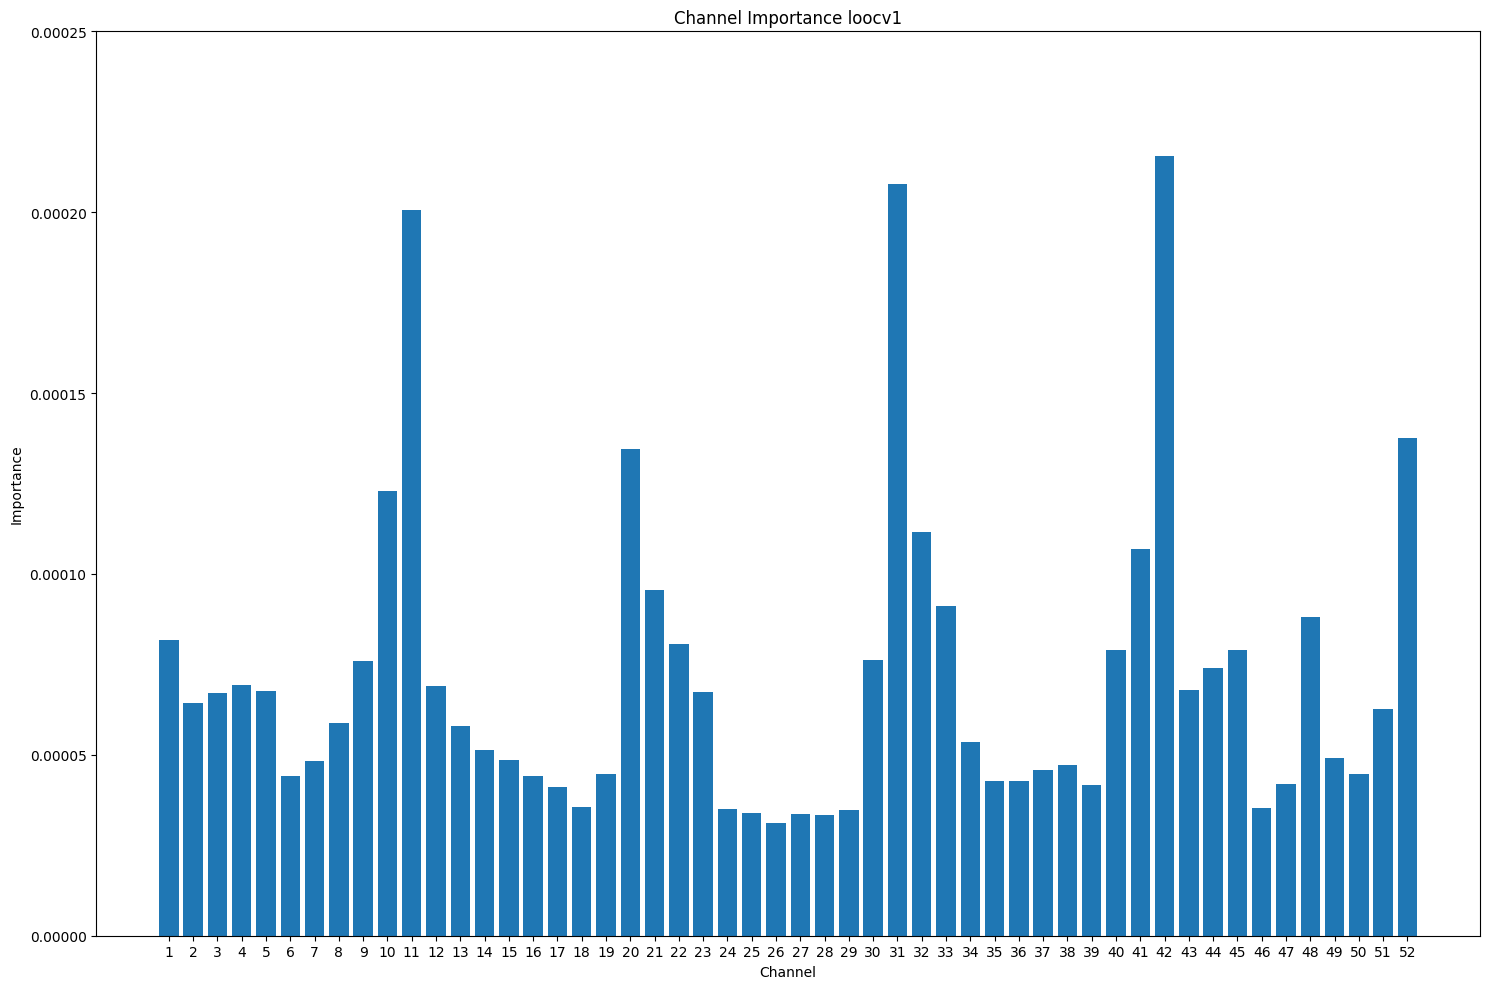

Ranked channels by importance: [11 31 42 20 10 32 33 52 41 22]


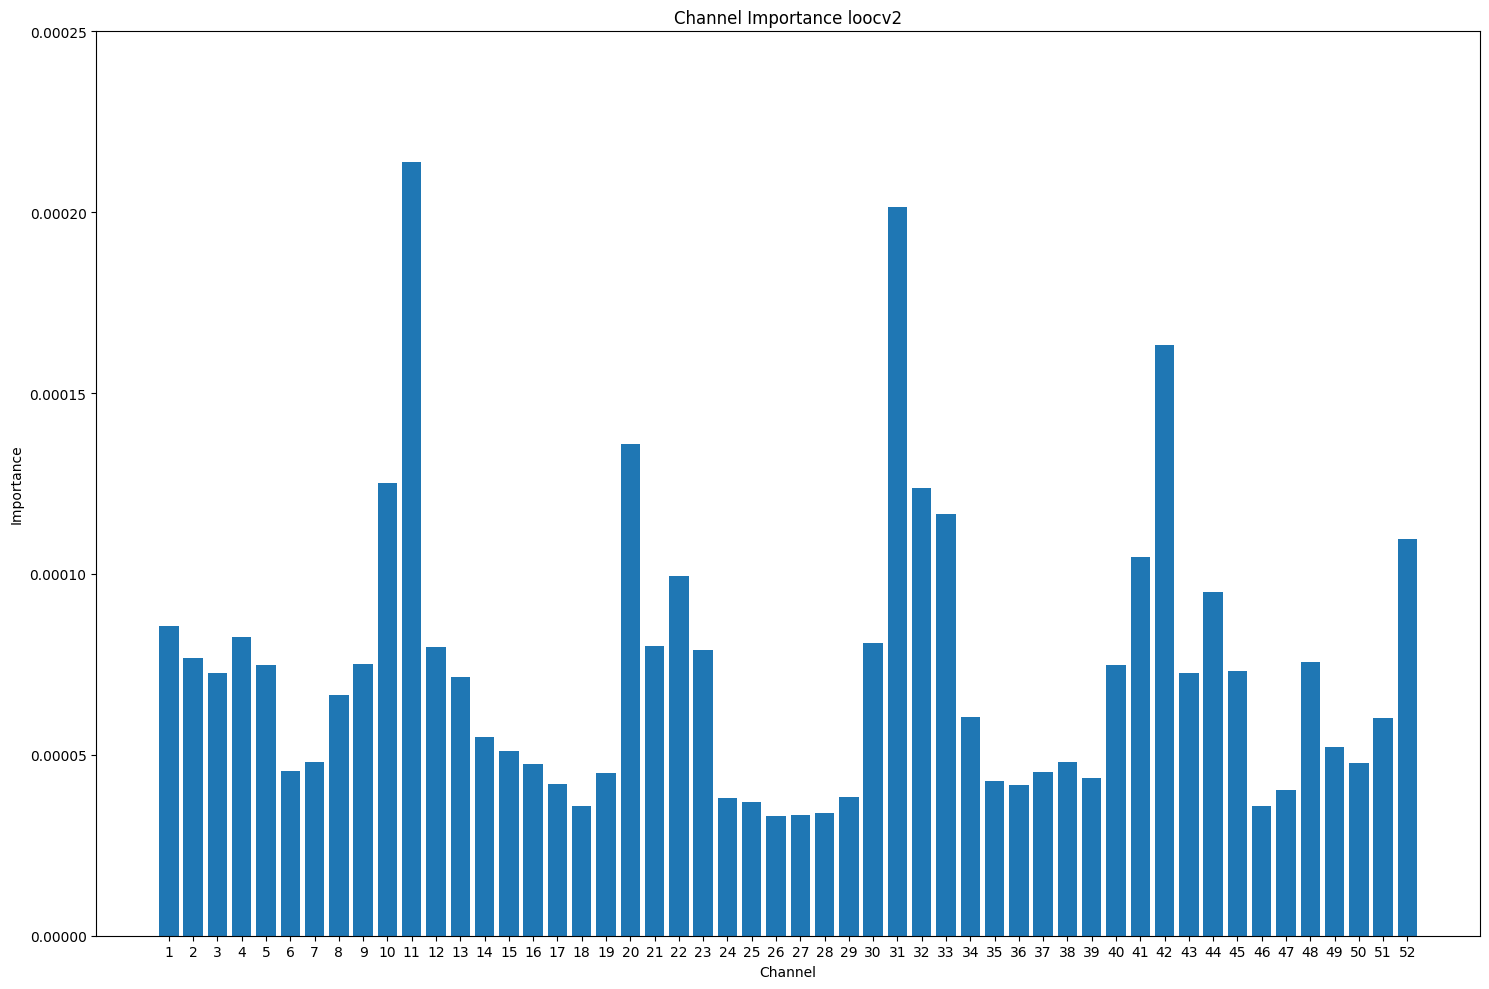

Ranked channels by importance: [11 31 42 32 20 10 33 52 41 44]


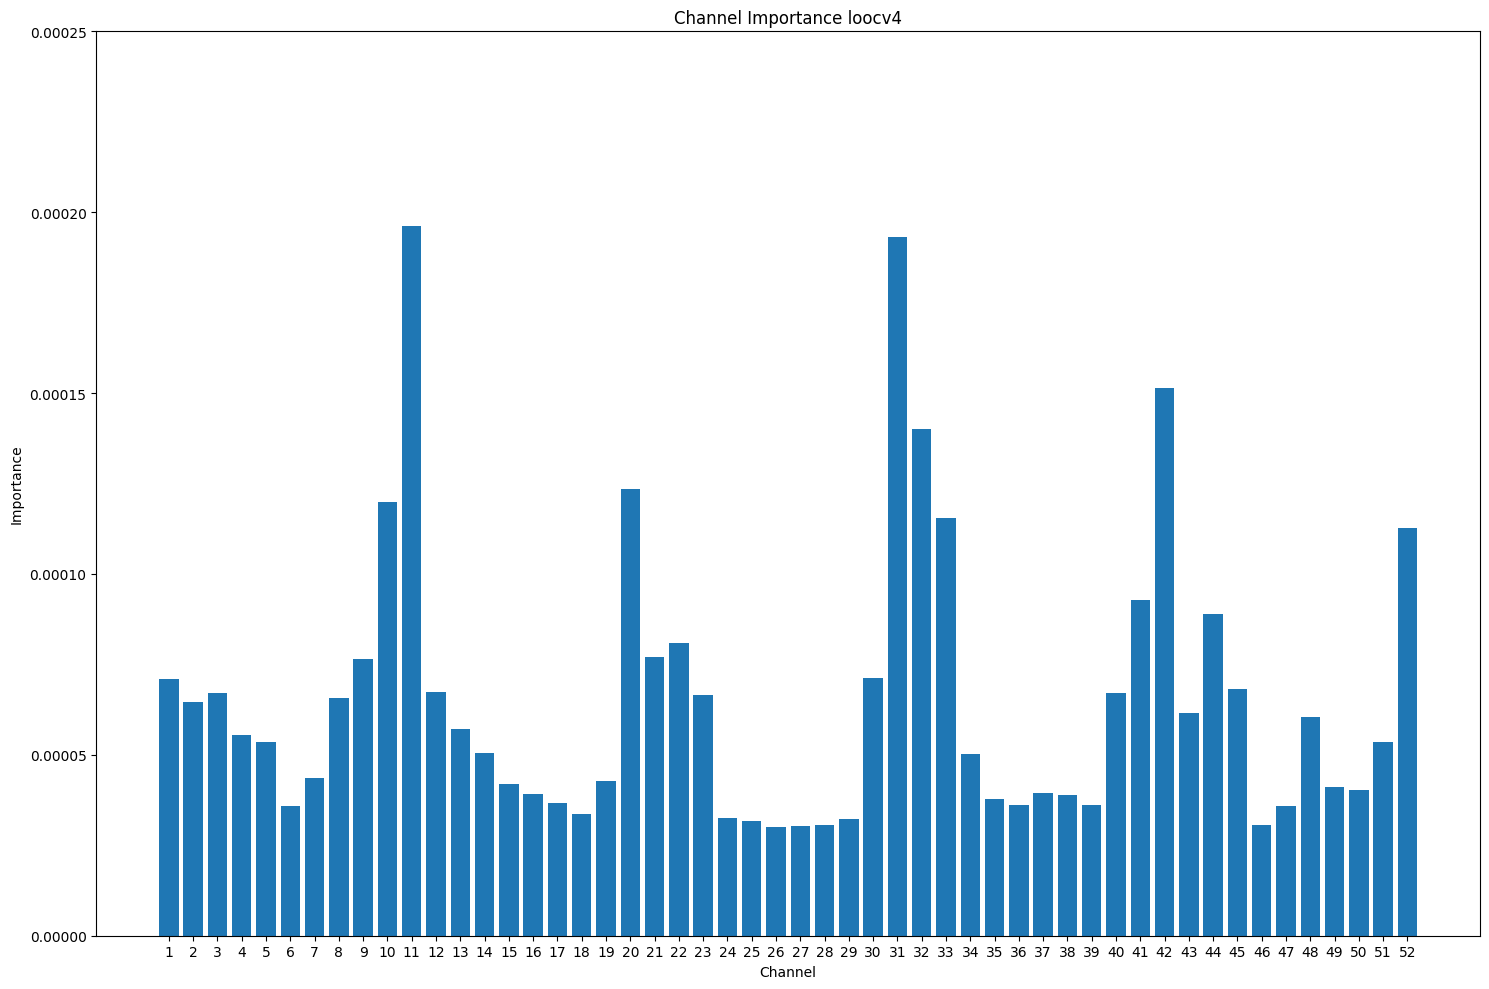

In [54]:
show_shap_channel_importance(loocv1, 'loocv1')
show_shap_channel_importance(loocv2, 'loocv2')
show_shap_channel_importance(loocv4, 'loocv4')

Ranked channels by importance: [26 27 28 46 25 29 24 18  6 47 36 39 17 35 38 16 37 50 49 15 19  7 34 14
 51  5  4 13 48 43  2  8 23  3 40 12 45  1 30  9 21 22 44 41 52 33 10 20
 32 42 31 11]


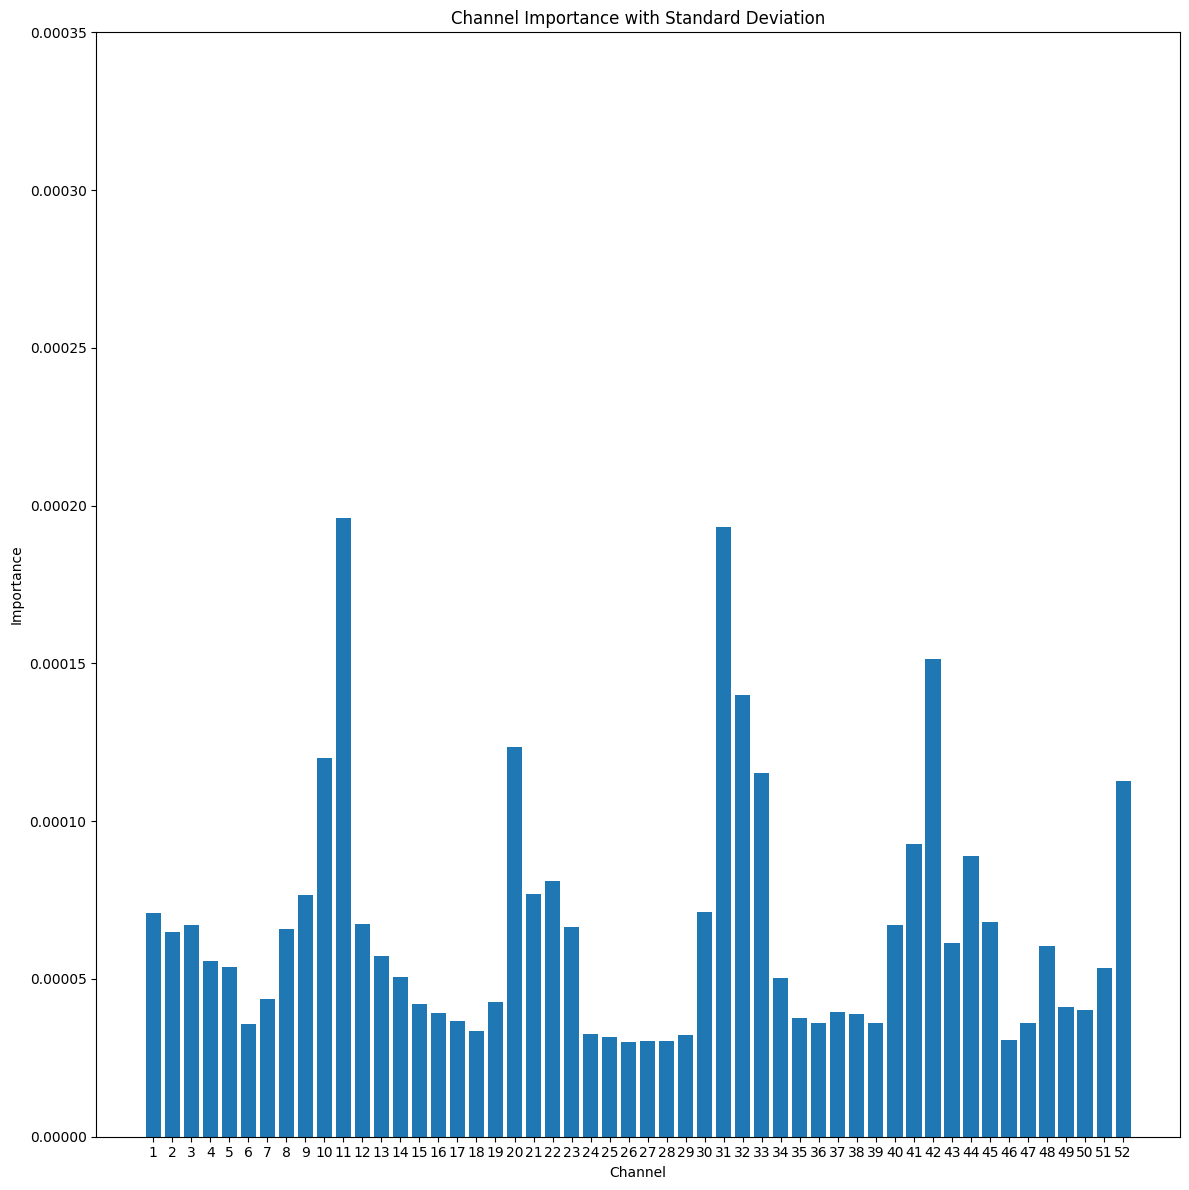

In [31]:
loocv = np.concatenate([loocv2, loocv4], axis=0)
show_shap_channel_importance(loocv)